In [4]:
import pandas as pd
import altair as alt
from altair import datum

In [5]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# Polio cases by state from 1928-1969

**Note: Data is normalized cases per 100,000 people for each state**

- [Downloaded from visdatasets](https://visdatasets.github.io/)
- Original Retrieved from [Project Tycho](https://www.tycho.pitt.edu/); aggregated into yearly values.
- [Good article on visualizations of this data](http://www.randalolson.com/2016/03/04/revisiting-the-vaccine-visualizations/)


In [6]:
polio = pd.read_excel('data/polio_incidence_rates_united_states.xlsx', sheet_name='polio_incidence_rates')
polio.head()

,year,state,cases
0,1928,Alabama,2.39
1,1928,Alaska,0.00
2,1928,Arizona,2.61
3,1928,Arkansas,0.52
4,1928,California,5.04


In [7]:
vacc = pd.DataFrame([{"Introduction": 1955}])

## Timeline of total incidence per year (summed over all states)

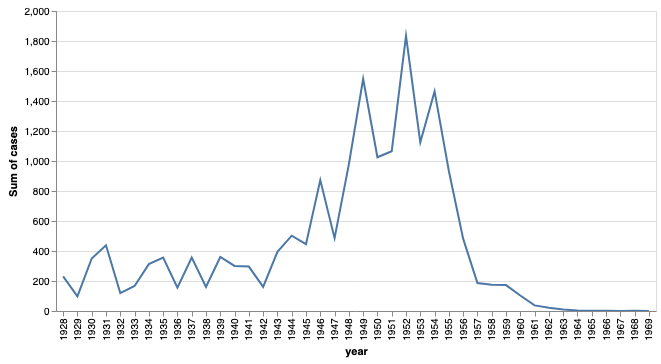

In [8]:
alt.Chart(polio).mark_line().encode(
    x = 'year:O',
    y = 'sum(cases):Q'
).properties(
    width = 600
)

## Timeline overlaying (detail) all states

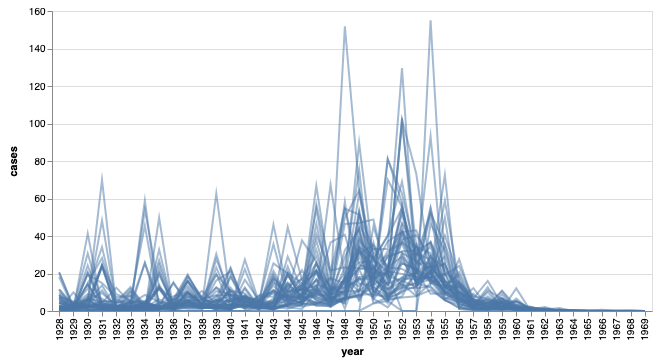

In [9]:
alt.Chart(polio).mark_line(opacity=0.5).encode(
    x = 'year:O',
    y = 'cases:Q',
    detail = 'state:N',
    tooltip = 'state:N'
).properties(
    width = 600
)

## Timeline of all states overlayed with mean cases across states

Also adding rule at 1955 introduction of vaccine

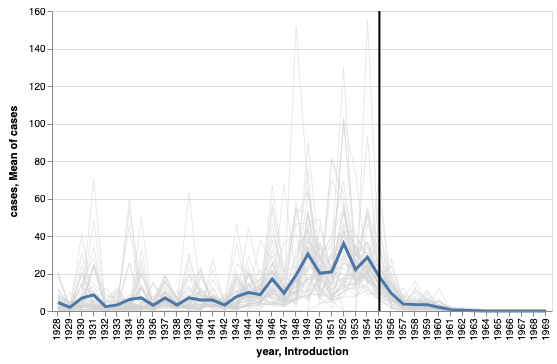

In [10]:
state_lines = alt.Chart(polio).mark_line(
    strokeWidth=0.5,
    color = 'lightgray'
).encode(
    x = 'year:O',
    y = 'cases:Q',
    detail = 'state:N'
).properties(
    width = 500
)

mean_line = alt.Chart(polio).mark_line(strokeWidth=3).encode(
    x = 'year:O',
    y = 'mean(cases):Q'
)

rule = alt.Chart(vacc).mark_rule().encode(
    x='Introduction:O',
    size = alt.value(2)
)

state_lines + mean_line + rule

## Median line with upper and lower quartile boundaries

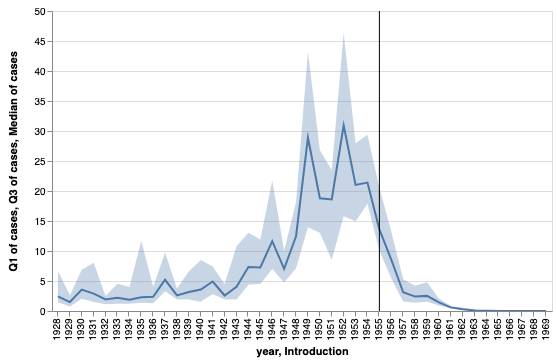

In [11]:
base = alt.Chart(polio).properties(width=500)

line = base.mark_line().encode(
    x='year:O',
    y='median(cases):Q'
)

confidence_interval = base.mark_area(opacity=0.3).encode(
    x ='year:O',
    y = 'q1(cases)',
    y2 = 'q3(cases)'
)

rule = alt.Chart(vacc).mark_rule().encode(
    x='Introduction:O'
)

confidence_interval + line + rule

## Mean line with 95% confidence intervals

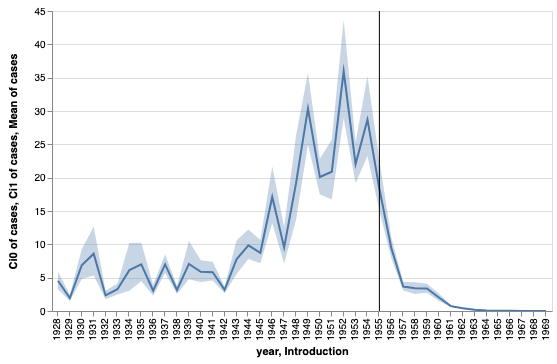

In [12]:
base = alt.Chart(polio).properties(width=500)

line = base.mark_line().encode(
    x='year:O',
    y='mean(cases):Q'
)

confidence_interval = base.mark_area(opacity=0.3).encode(
    x = 'year:O',
    y = 'ci0(cases):Q',
    y2 = 'ci1(cases):Q'
)

rule = alt.Chart(vacc).mark_rule().encode(
    x='Introduction:O'
)

confidence_interval + line + rule

## Bar chart of sum of incidents by state (over all time)

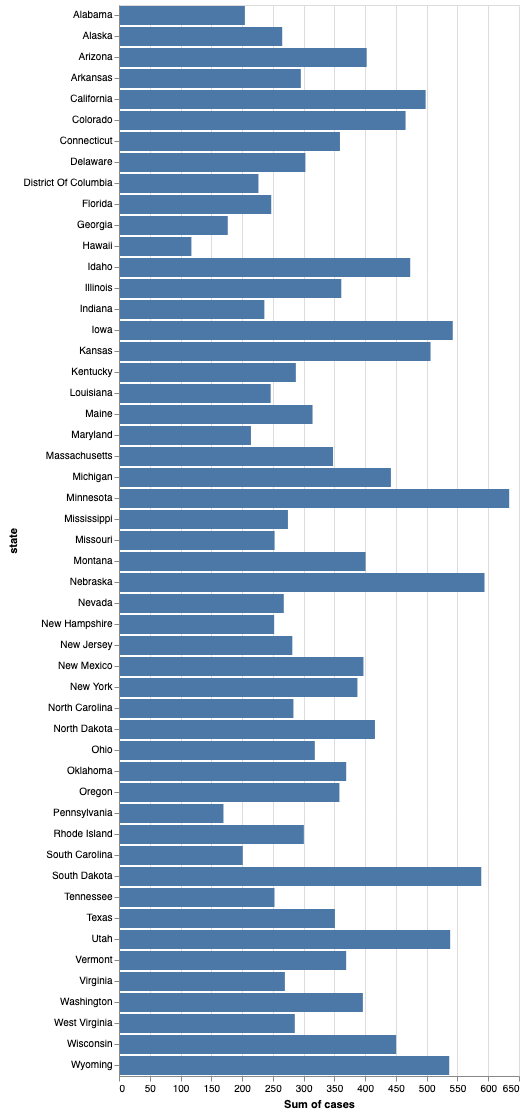

In [13]:
alt.Chart(polio).mark_bar().encode(
    x = 'sum(cases):Q',
    y = 'state:N'
)

## Top 10 bar chart of summed cases per state, sorted (descending) by number of cases

`transform_window()` is currently very poorly documented in Altair. It's purpose is to do things like running averages and rank calculations. In Tableau, these are usually "table calculations".

- [Pulled from this example](https://github.com/altair-viz/altair/blob/master/altair/examples/top_k_letters.py)

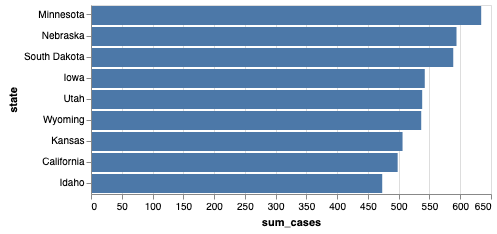

In [14]:
alt.Chart(polio).mark_bar().encode(
    x = 'sum_cases:Q',
    y = alt.Y('state',
            sort=alt.EncodingSortField(
                field="sum_cases",
                op="sum",
                order="descending")
    )
).transform_aggregate(
    sum_cases='sum(cases)',
    groupby=['state']
).transform_window(
    rank = 'rank(sum_cases)',
    sort=[alt.SortField('sum_cases', order='descending')]
).transform_filter(
    alt.datum.rank < 10
)

## Heatmap of cases by state and year

[Vega-Lite color schemes](https://vega.github.io/vega/docs/schemes/)

*(Note: To see the trend more clearly, limit the color scale domain from 0-50.)*

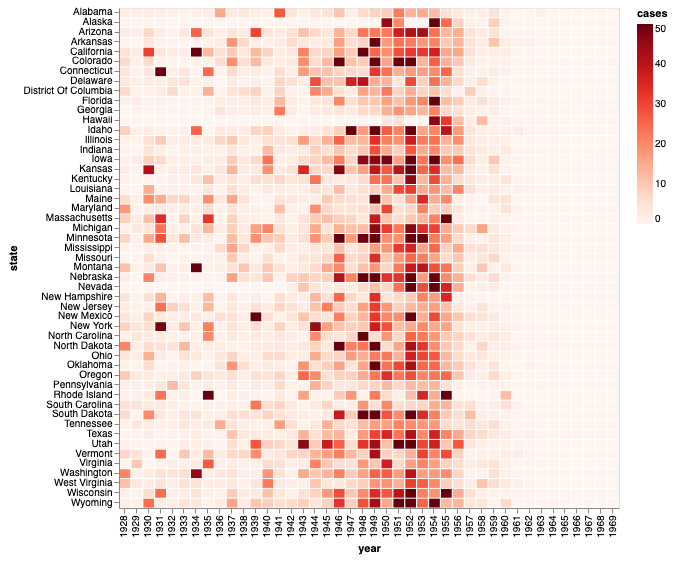

In [15]:
alt.Chart(polio).mark_rect().encode(
    x = 'year:O',
    y = 'state:N',
    color = alt.Color('cases:Q', scale=alt.Scale(scheme='reds', domain=[0,50]))
).properties(
    width = 500,
    height = 500
)

## Heatmap with states sorted by sum of cases

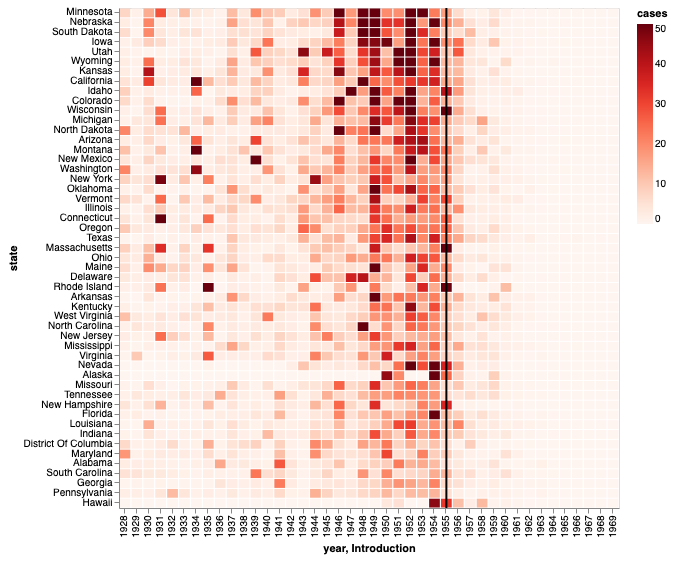

In [16]:
heatmap = alt.Chart(polio).mark_rect().encode(
    x = 'year:O',
    y = alt.Y('state',
            sort=alt.EncodingSortField(
                field="cases",
                op="sum",
                order="descending")
    ),
    color = alt.Color('cases:Q', scale=alt.Scale(scheme='reds', domain=[0,50]))
).properties(
    width = 500,
    height = 500
)

rule = alt.Chart(vacc).mark_rule().encode(
    x='Introduction:O',
    size=alt.value(2)
)

heatmap + rule

## US States Symbol Map

US map with a circle for each state showing the total number of cases over the years for that state.

In [34]:
state_locs = pd.read_excel('data/polio_incidence_rates_united_states.xlsx', sheet_name='state_locations')
state_locs.head()

,state,latitude,longitude
0,Alabama,32.806671,-86.791130
1,Alaska,61.370716,-152.404419
2,Arizona,33.729759,-111.431221
3,Arkansas,34.969704,-92.373123
4,California,36.116203,-119.681564


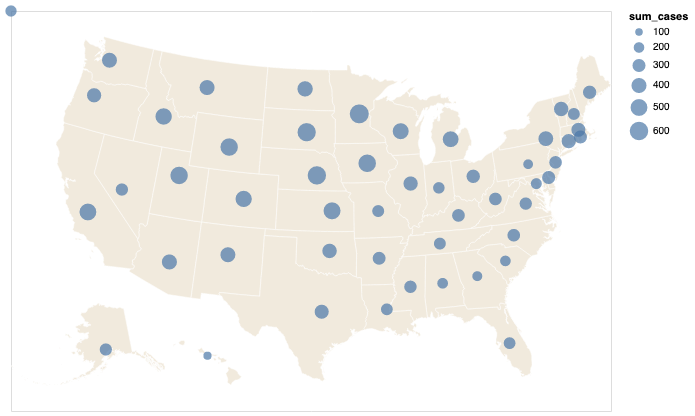

In [35]:
states = alt.topo_feature('https://vega.github.io/vega-datasets/data/us-10m.json', 'states')
proj_type = 'albersUsa'
width = 600
height = 400

background = alt.Chart(states).mark_geoshape(
    fill='#e5d8bd',
    stroke='white',
    opacity=0.5
).project(
    type = proj_type
).properties(
    width = width,
    height = height
)

points = alt.Chart(polio).mark_circle().encode(
    longitude = 'longitude:Q',
    latitude = 'latitude:Q',
    size = 'sum_cases:Q',
    tooltip = ['state:N','sum_cases:Q']
).transform_aggregate(
    sum_cases='sum(cases)',
    groupby=['state']
).transform_lookup(
    lookup = "state",
    from_ = alt.LookupData(data=state_locs, key='state', fields=['latitude','longitude'])
).project(
    type = proj_type
).properties(
    width = width,
    height = height
)

background + points